In [27]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output, Image

from original_utils import *

import importlib
import sys
importlib.reload(sys.modules['original_utils'])
from original_utils import *

device_id = 2
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:2


In [28]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

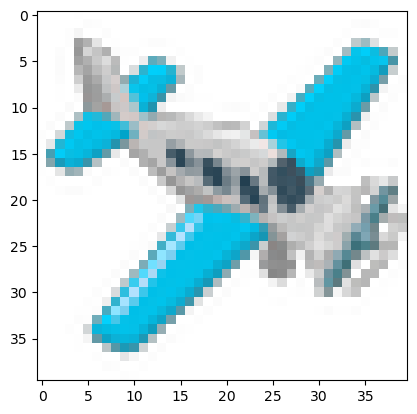

In [29]:
plt.imshow(target_img)
plt.show()

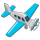

In [4]:
imshow(target_img)

In [30]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    # self.dmodel[-1].weight.data *= 0
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    
    kernel = stacked_filters.tile((self.channel_n, 1, 1))
    y = F.conv2d(x, kernel[:, None, :, :], padding='same', groups=self.channel_n)    
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)).contiguous() # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [31]:
pad_target.device

device(type='cpu')

seed shape is torch.Size([72, 72, 16])


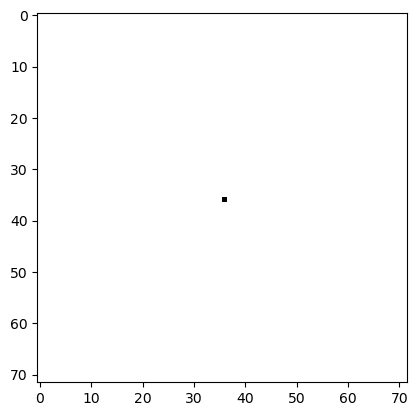

In [32]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [33]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, lr=2e-3):
    self.ca = ca_model
    self.target = einops.repeat(target, '... -> b ...', b=BATCH_SIZE)
    self.lr = lr
    # Initialize optimizer with lr scheduler
    # self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr, weight_decay=1e-8)
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    self.scheduler = torch.optim.lr_scheduler.MultiStepLR(
        self.optim, milestones=[2000], gamma=0.1)
    
    # # Use library MSELoss
    # self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = []

  def train(self, x0, n_steps=1001):
    "Just support Growing mode for now"

    for i in range(n_steps+1):

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')

      # Printing
      if i % 100 == 0:
        clear_output()

        # visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # plot loss
        plot_loss(self.loss_log)
        
        # export model

      print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    # loss = self.loss_f(to_rgba(x), self.target)
    loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Apply L2 normalization to parameter gradients as per original paper
    for p in self.ca.parameters():
      if p.grad is not None:
        p.grad = p.grad / (p.grad.norm() + 1e-8)     
    
    # Update parameters
    self.optim.step()
    
    # Update learning rate step
    self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


batch (before/after):


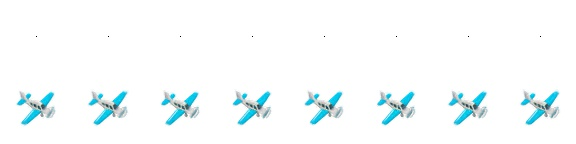

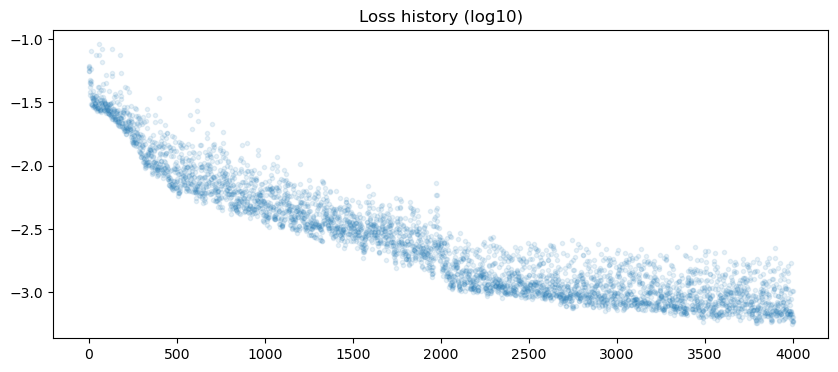

 step: 4002, log10(loss): -3.255CPU times: user 10min 35s, sys: 9.63 s, total: 10min 44s
Wall time: 8min 55s


In [34]:
%%time
# original torch conv layer initialization WITH gradient norm AND lr scheduler (FIXED)

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=4001)

batch (before/after):


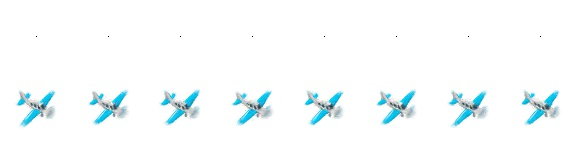

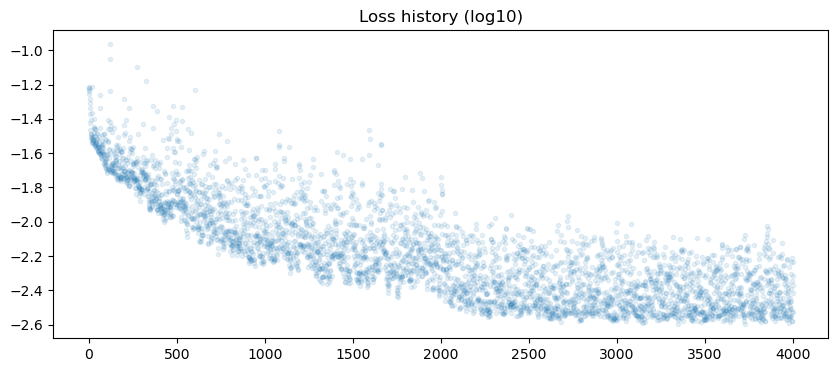

 step: 4002, log10(loss): -2.534CPU times: user 12min 35s, sys: 10.1 s, total: 12min 45s
Wall time: 10min 51s


In [10]:
%%time
# original torch conv layer initialization WITH gradient norm AND lr scheduler

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=4001)

batch (before/after):


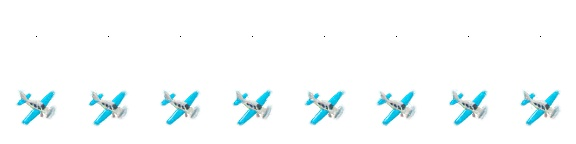

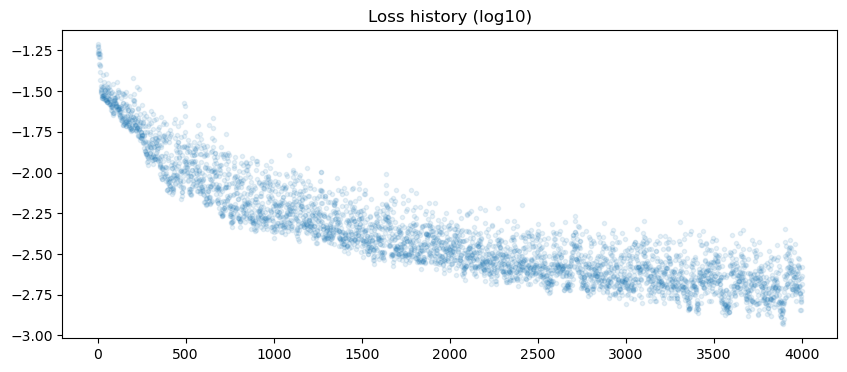

 step: 4001, log10(loss): -2.625CPU times: user 10min 43s, sys: 7.16 s, total: 10min 51s
Wall time: 8min 48s


In [170]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=4001)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 385.56it/s]


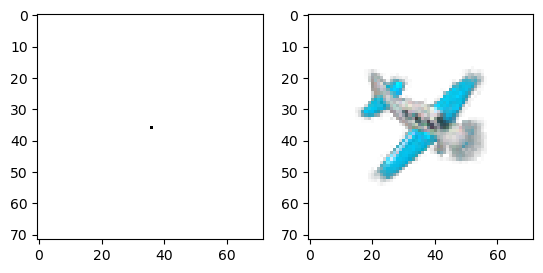

In [26]:
x = simulate_model(ca, seed.unsqueeze(0), 78, device=device)